# Лабораторна робота 2
## обраний датасет можна завантажити за посиланням (ось [тут](https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection))

In [1]:
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
from typing import Tuple, Union
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import Sequence
from keras.models import Sequential, load_model
from keras.layers import Conv2D
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm

2023-05-31 11:39:59.433794: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-31 11:39:59.491420: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 11:39:59.751821: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 11:39:59.753385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 11:40:00.627398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
RS = 47
CORES = mp.cpu_count()
np.random.seed(RS)

In [3]:
DATA_DIR = Path('../data/lab2/images').resolve()
metadata_full = pd.read_csv(DATA_DIR.parent / 'faces.csv')
metadata_full

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158
3346,00002232.jpg,620,349,122,103,344,248
3347,00002232.jpg,620,349,258,118,541,303
3348,00002232.jpg,620,349,215,11,362,108


In [4]:
metadata_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  3350 non-null   object
 1   width       3350 non-null   int64 
 2   height      3350 non-null   int64 
 3   x0          3350 non-null   int64 
 4   y0          3350 non-null   int64 
 5   x1          3350 non-null   int64 
 6   y1          3350 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 183.3+ KB


In [5]:
metadata = metadata_full.drop_duplicates(subset=['image_name'])
metadata.shape

(2204, 7)

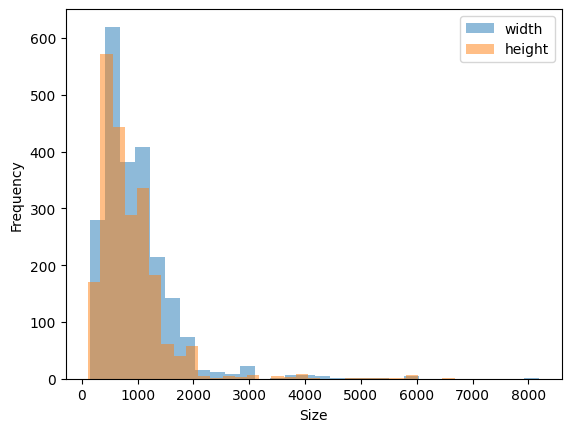

In [6]:
plt.hist(metadata.width, bins=30, alpha=0.5, label='width')
plt.hist(metadata.height, bins=30, alpha=0.5, label='height')

plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

In [7]:
# maybe skip small images, it would be better for task 2
metadata_selected = (
    metadata
    .query("width <= 1024 & height <= 1024")
    .sample(frac=0.5, random_state=RS)
    .reset_index(drop=True)
)
metadata_selected

,image_name,width,height,x0,y0,x1,y1
0,00001282.jpg,333,519,187,20,228,93
1,00003045.jpg,700,466,390,107,550,230
2,00000366.jpg,900,601,170,88,506,350
3,00000619.jpg,1024,683,157,257,416,458
4,00001693.jpg,1023,682,406,50,796,352
...,...,...,...,...,...,...,...
693,00001386.jpg,760,434,136,1,682,347
694,00003296.jpg,612,408,238,177,411,311
695,00002472.jpg,640,468,177,154,282,243
696,00000974.jpg,462,280,77,34,183,108


In [8]:
SCALE = 2
INPUT_DIM = 33
LABEL_SIZE = 19
PAD = int((INPUT_DIM - LABEL_SIZE) / SCALE)
STRIDE = 14
PATCH_DIR = DATA_DIR.parent / 'patches_more_19x19'

In [9]:
def downsize_upsize_image(image: np.ndarray, scale: int) -> np.ndarray:
    height, width = (np.array(image.shape[:-1]) / scale).astype(int)

    lr_image = np.array(
        Image.fromarray(image)
        .resize([width, height], Image.BICUBIC)
        .resize([width * scale, height * scale], Image.BICUBIC)
    )

    return lr_image


def tight_crop_image(image: np.ndarray, scale: int) -> np.ndarray:
    height, width = (np.array(image.shape[:-1]) // scale * scale).astype(int)
    image = tf.image.crop_to_bounding_box(image, 0, 0, height, width).numpy()
    return image


def crop_image(image: np.ndarray, x: int, y: int, size: int) -> np.ndarray:
    image = tf.image.crop_to_bounding_box(image, y, x, size, size).numpy()
    return image

In [10]:
def process_image(
    img_path: Path, scale: int, downscale_resolution: bool = False
) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    image = np.array(tf.keras.utils.load_img(img_path))
    image = tight_crop_image(image, scale)

    if downscale_resolution:
        scaled = downsize_upsize_image(image, scale)
        return image, scaled
    return image


def extract_patches_and_save(row: pd.Series) -> int:
    filename = row['image_name']

    try:
        image, lr_image = process_image(DATA_DIR / filename, SCALE, downscale_resolution=True)

        height, width = image.shape[:2]
        filename = Path(filename).stem

        for y in range(0, height - INPUT_DIM + 1, STRIDE):
            for x in range(0, width - INPUT_DIM + 1, STRIDE):
                crop = crop_image(lr_image, x, y, INPUT_DIM)
                target = crop_image(image, x + PAD, y + PAD, LABEL_SIZE)

                np.save(PATCH_DIR / f'{filename}_{x}_{y}_input.np', crop)
                np.save(PATCH_DIR / f'{filename}_{x}_{y}_output.np', target)
    except Exception as e:
        print(f"{filename}: {e}")
        return 0
    return 1

In [11]:
if not PATCH_DIR.exists():
    PATCH_DIR.mkdir(exist_ok=True)
    step_printing = metadata_selected.shape[0] // 10
    count = 0
    with ProcessPoolExecutor(max_workers=CORES) as executor:
        futures = {executor.submit(extract_patches_and_save, row): index for index, row in metadata_selected.iterrows()}
        for future in as_completed(futures):
            count += future.result()
            if count % step_printing == 0:
                print(f"Processed {count}/{metadata_selected.shape[0]} images")
        print(f"Processed {round(count / metadata_selected.shape[0] * 100, 1)}% images")

In [12]:
intersaction_np_files = set(i.stem.removesuffix('_input.np') for i in PATCH_DIR.glob('*input*')) \
                          & set(i.stem.removesuffix('_output.np') for i in PATCH_DIR.glob('*output*'))
len(intersaction_np_files)

1286350

In [13]:
intersaction_np_files = sorted(intersaction_np_files)

In [14]:
intersaction_np_files[:5]

['00000018_0_0',
 '00000018_0_112',
 '00000018_0_126',
 '00000018_0_14',
 '00000018_0_140']

In [15]:
class PatchesDataloader(Sequence):
    def __init__(self, batch_size: int):
        self.batch_size = batch_size
        
        input_l, output_l = [], []
        for file_stem in intersaction_np_files:
            input_l.append(PATCH_DIR / f'{file_stem}_input.np.npy')
            output_l.append(PATCH_DIR / f'{file_stem}_output.np.npy')

        self.input = input_l
        self.output = output_l
        self.total_data = len(self.input)

    def __len__(self):
        return int(self.total_data / self.batch_size)

    def __getitem__(self, index):
        indices = range(index * self.batch_size, (index + 1) * self.batch_size)
        
        input = np.array([np.load(self.input[idx]) for idx in indices])
        output = np.array([np.load(self.output[idx]) for idx in indices])
        
        return input, output

In [16]:
%%time
BATCH_SIZE = 1024
train_dl = PatchesDataloader(BATCH_SIZE)

CPU times: user 10.1 s, sys: 219 ms, total: 10.4 s
Wall time: 10.4 s


In [17]:
train_dl[0][0].shape

(1024, 33, 33, 3)

In [18]:
train_dl[0][1].shape

(1024, 19, 19, 3)

In [19]:
len(train_dl)

1256

In [21]:
def model_SRCNN(height: int, width: int, depth: int = 3):
    SRCNN = Sequential()
    SRCNN.add(Conv2D(64, (9, 9), activation='relu', input_shape=(height, width, depth)))
    SRCNN.add(Conv2D(32, (3, 3), activation='relu'))
    SRCNN.add(Conv2D(3, (5, 5), activation='linear'))
    return SRCNN

SRCNN = model_SRCNN(INPUT_DIM, INPUT_DIM)
SRCNN.compile(optimizer='adam', loss='mean_squared_error')
SRCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 64)        15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 3)         2403      
                                                                 
Total params: 36,483
Trainable params: 36,483
Non-trainable params: 0
_________________________________________________________________


In [22]:
CHECKPOINTS_DIR = DATA_DIR.parent / 'checkpoints'
CHECKPOINTS_DIR.mkdir(exist_ok=True)

checkpoint = ModelCheckpoint(CHECKPOINTS_DIR / "best_model_SRCNN.hdf5", monitor='loss', verbose=1,
    save_best_only=True, save_freq='epoch')

In [23]:
history = SRCNN.fit(train_dl, epochs=10, callbacks=[checkpoint], use_multiprocessing=True, workers=CORES)

Epoch 1/10


2023-05-31 11:45:32.738042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1256/1256 [==============================] - ETA: 0s - loss: 281.9000
Epoch 1: loss improved from inf to 281.89999, saving model to /home/prokhor/PycharmProjects/pythonProject1/data/lab2/checkpoints/best_model_SRCNN.hdf5
1256/1256 [==============================] - 1105s 878ms/step - loss: 281.9000
Epoch 2/10
1256/1256 [==============================] - ETA: 0s - loss: 135.1491
Epoch 2: loss improved from 281.89999 to 135.14909, saving model to /home/prokhor/PycharmProjects/pythonProject1/data/lab2/checkpoints/best_model_SRCNN.hdf5
1256/1256 [==============================] - 1100s 873ms/step - loss: 135.1491
Epoch 3/10
1256/1256 [==============================] - ETA: 0s - loss: 96.5907
Epoch 3: loss improved from 135.14909 to 96.59074, saving model to /home/prokhor/PycharmProjects/pythonProject1/data/lab2/checkpoints/best_model_SRCNN.hdf5
1256/1256 [==============================] - 1091s 866ms/step - loss: 96.5907
Epoch 4/10
1256/1256 [==============================] - ETA: 0s - los

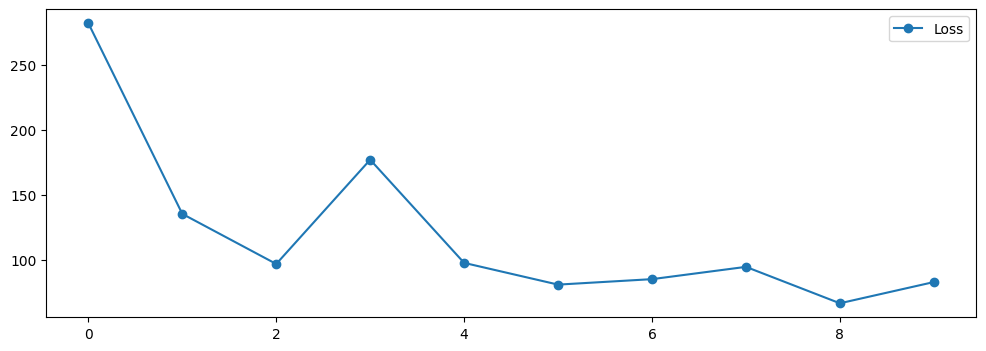

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], 'o-', label='Loss')
plt.legend()
plt.show()

In [25]:
def get_enhanced_image(img: np.ndarray, verbose: int = 0) -> np.ndarray:
    output = np.zeros(img.shape)
    height, width = output.shape[:-1]

    input_patches, output_slices = [], []
    for y in range(0, height - INPUT_DIM + 1, LABEL_SIZE):
        for x in range(0, width - INPUT_DIM + 1, LABEL_SIZE):
            crop = crop_image(img, x, y, INPUT_DIM)
            input_patches.append(crop)

            output_y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
            output_x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
            output_slices.append((output_y_slice, output_x_slice))

    input_patches = np.array(input_patches)

    # Make the predictions in one batch
    predictions = SRCNN_model.predict(input_patches, verbose=verbose)

    for prediction, (output_y_slice, output_x_slice) in zip(predictions, output_slices):
        output[output_y_slice, output_x_slice] = prediction
    
    output = np.clip(output, 0, 255).astype(np.uint8)
    
    if verbose:
        print(f"input shape: {(height, width)}\noutput shape: {output.shape[:-1]}")
    
    return output


def get_image_without_pad(image: np.ndarray) -> np.ndarray:
    height, width = image.shape[:-1]
    
    y_slice = slice(PAD, height - PAD - (height - INPUT_DIM) % LABEL_SIZE)
    x_slice = slice(PAD, width - PAD - (width - INPUT_DIM) % LABEL_SIZE)
    
    return image[y_slice, x_slice]


def plot_image(image: np.ndarray, title: str = "", without_pad: bool = False) -> None:
    if without_pad:
        image = get_image_without_pad(image)

    image = Image.fromarray(image)
    
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

In [26]:
SRCNN_model = load_model(CHECKPOINTS_DIR / 'best_model_SRCNN.hdf5')

In [27]:
random_data = metadata_selected.sample(n=1, random_state=RS)
random_img_path = DATA_DIR / random_data['image_name'].to_list()[0]
random_data

,image_name,width,height,x0,y0,x1,y1
622,00001937.jpg,800,533,258,32,474,196


In [28]:
original_image, lr_image = process_image(random_img_path, SCALE, downscale_resolution=True)

In [29]:
output = get_enhanced_image(lr_image, verbose=1)

35/35 [==============================] - 1s 12ms/step
input shape: (532, 800)
output shape: (532, 800)


PSNR Achieved: 17.49


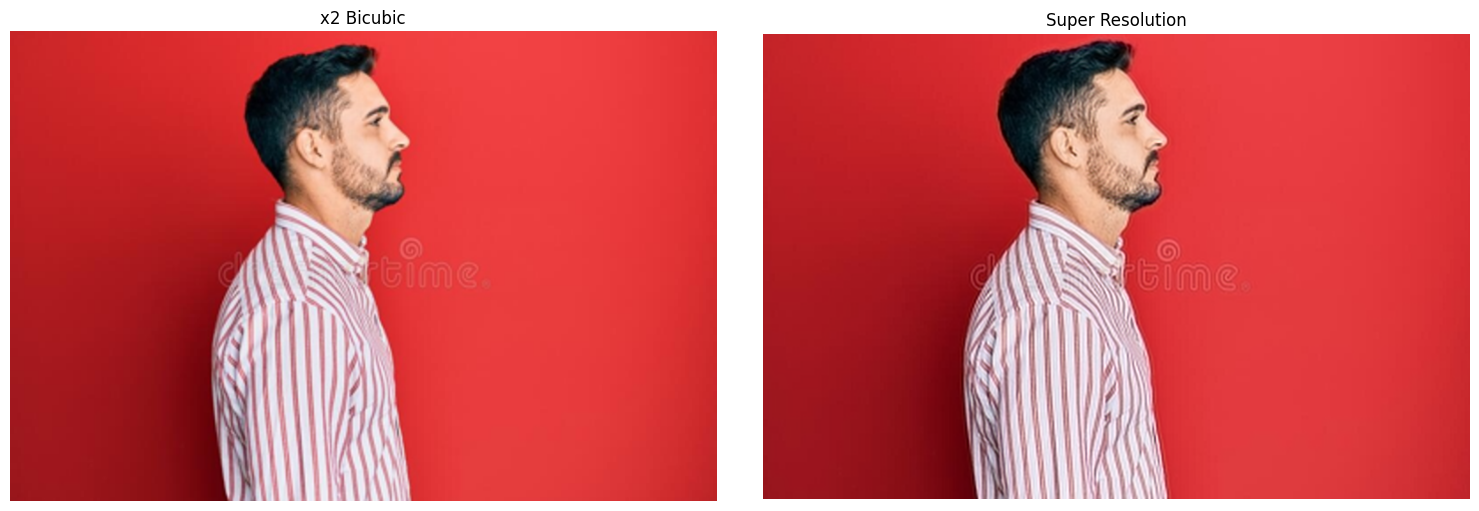

In [30]:
figure, axis = plt.subplots(1, 2, figsize=(15, 8))
figure.tight_layout()
plt.subplot(121)
plot_image(lr_image, f"x{SCALE} Bicubic")
figure.tight_layout()
plt.subplot(122)
plot_image(output, "Super Resolution", True)

psnr = tf.image.psnr(output, original_image, max_val=255)
print(f"PSNR Achieved: {psnr:.2f}")

In [31]:
output_original_enh = get_enhanced_image(original_image)

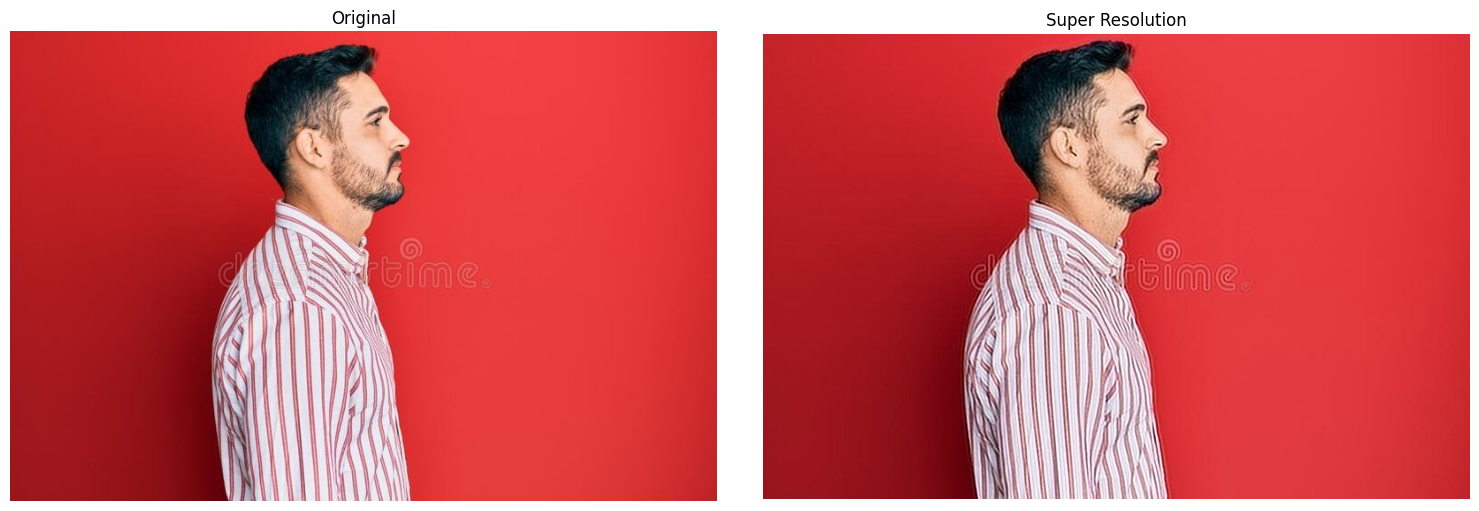

In [32]:
figure, axis = plt.subplots(1, 2, figsize=(15, 8))
figure.tight_layout()
plt.subplot(121)
plot_image(original_image, "Original")
figure.tight_layout()
plt.subplot(122)
plot_image(output_original_enh, "Super Resolution", True)

In [33]:
def inference_and_save_image(img_path: Path, img_path_out: Path) -> None:
    try:
        image = process_image(img_path, SCALE)
        image = get_enhanced_image(image)
        image = get_image_without_pad(image)
        Image.fromarray(image).save(img_path_out)
    except Exception as e:
        print(f"{img_path}: {e}")

In [34]:
ENHANCED_IMAGES_DIR = DATA_DIR.parent / 'images_enhanced'

if not ENHANCED_IMAGES_DIR.exists():
    ENHANCED_IMAGES_DIR.mkdir(exist_ok=True)

    total_imgs = metadata_selected['image_name'].tolist()
    for img_name in tqdm(total_imgs, total=len(total_imgs)):
        inference_and_save_image(DATA_DIR / img_name, ENHANCED_IMAGES_DIR / img_name)

100%|█████████████████████████████████████████| 698/698 [14:43<00:00,  1.27s/it]


## Друге завдання

In [35]:
from functools import partial
from collections import defaultdict

import keras
import matplotlib.cm as cm
from PIL import ImageDraw
from sklearn.model_selection import train_test_split
from keras.layers import MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

IMAGE_SIZE = (256, 256)  # (height, width)

In [80]:
def get_norm_image_and_face_box(row: pd.Series, root_dir: Path) -> Tuple[np.ndarray, np.ndarray]:    
    image = Image.open(root_dir / row['image_name'])
    width, height = image.size
    
    x0 = int((row['x0'] / width) * IMAGE_SIZE[1]) / IMAGE_SIZE[1]
    y0 = int((row['y0'] / height) * IMAGE_SIZE[0]) / IMAGE_SIZE[0]
    x1 = int((row['x1'] / width) * IMAGE_SIZE[1]) / IMAGE_SIZE[1]
    y1 = int((row['y1'] / height) * IMAGE_SIZE[0]) / IMAGE_SIZE[0]
    face_box = np.array([x0, y0, x1, y1])
    
    image = (
        image
        .convert('L')
        .resize(IMAGE_SIZE, Image.LANCZOS)
    )
    image = np.array(image) / 255.

    return image, face_box
    

# 1 face_box per 1 image
def load_dataset(df: pd.DataFrame, mode: str = "default") -> dict:
    assert mode in ["default", "enhanced"]
    
    dataset = defaultdict(dict)
    
    r_d = {"default" : DATA_DIR, "enhanced": ENHANCED_IMAGES_DIR}
    step_printing = df.shape[0] // 10
    get_norm_image_and_face_box_partial = partial(get_norm_image_and_face_box, root_dir=r_d[mode])
    
    with ProcessPoolExecutor(max_workers=CORES) as executor:
        futures = {executor.submit(get_norm_image_and_face_box_partial, row): row['image_name'] for _, row in df.iterrows()}
        for future in as_completed(futures):
            index = futures[future]
            image, face_box = future.result()
            
            dataset[index].update({"image": image, "box": face_box})
            
            if len(dataset) % step_printing == 0:
                print(f"Processed {len(dataset)}/{df.shape[0]} images")
    print(f"Processed {round(len(dataset) / df.shape[0] * 100, 1)}% images")
    
    return dataset


def get_image_and_box_dataset_from_dict(data_dict: dict) -> Tuple[np.ndarray, np.ndarray]:
    arr_img, arr_box = [], []
    
    for d in data_dict.values():
        arr_img.append(d['image'])
        arr_box.append(d['box'])
    assert len(arr_img) == len(arr_box)
    
    arr_box = np.array(arr_box)
    arr_img = np.array(arr_img)
    arr_img = np.expand_dims(arr_img, axis=-1)
    
    return arr_img, arr_box


def get_train_test_by_indexes(data_dict: dict, ids: Tuple[int]) -> Tuple[np.ndarray]:
    X_train_ids, X_test_ids, y_train_ids, y_test_ids = [np.array(ids[i]) - 1 for i in range(4)]
    images, face_boxes = get_image_and_box_dataset_from_dict(data_dict)

    X_train = images[X_train_ids]
    X_test = images[X_test_ids]
    y_train = face_boxes[y_train_ids]
    y_test = face_boxes[y_test_ids]
    
    return X_train, X_test, y_train, y_test


def model_CNN_face_detection(height: int, width: int):
    model = Sequential()
    model.add(Conv2D(32, 3, input_shape=(height, width, 1), activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(256, 3, activation='relu'))
    model.add(Dropout(0.4))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(4, activation = 'sigmoid'))
    return model


def plot_metric(history: keras.callbacks.History, metric: str, k: int = 5) -> None:
    assert metric in ['accuracy', 'loss'], "Wrong type of metric. Just use 'accuracy' or 'loss'"
    
    train_metrics = history.history[metric]
    val_metrics = history.history[f'val_{metric}']
    epochs = range(1, len(train_metrics) + 1)
    
    plt.plot(epochs, train_metrics, '-o', markersize=3, label=f"Training {metric}")
    plt.plot(epochs, val_metrics, label=f"Validation {metric}")
    
    plt.xticks([1] + [i for i in epochs if i % k == 0])
    
    plt.title(f'Training and validation {metric}')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()


def plot_image_with_predicted_box(model, image: np.ndarray) -> None:
    box = model.predict(np.expand_dims(image, axis=0))[0]
    
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image).convert('RGB')
    draw = ImageDraw.Draw(image)
    
    x0 = int(box[0] * IMAGE_SIZE[1])
    y0 = int(box[1] * IMAGE_SIZE[0])
    x1 = int(box[2] * IMAGE_SIZE[1])
    y1 = int(box[3] * IMAGE_SIZE[0])

    draw.rectangle(((x0, y0), (x1, y1)), outline='red')

    #image.show()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [37]:
default_dataset = load_dataset(metadata_selected, mode="default")

Processed 69/698 images
Processed 138/698 images
Processed 207/698 images
Processed 276/698 images
Processed 345/698 images
Processed 414/698 images
Processed 483/698 images
Processed 552/698 images
Processed 621/698 images
Processed 690/698 images
Processed 100.0% images


In [38]:
enhanced_dataset = load_dataset(metadata_selected, mode="enhanced")

Processed 69/698 images
Processed 138/698 images
Processed 207/698 images
Processed 276/698 images
Processed 345/698 images
Processed 414/698 images
Processed 483/698 images
Processed 552/698 images
Processed 621/698 images
Processed 690/698 images
Processed 100.0% images


In [39]:
indexes = list(range(len(default_dataset)))
tuple_of_indexes = train_test_split(indexes, indexes, test_size=0.25, random_state=RS)
X_train, X_test, y_train, y_test = get_train_test_by_indexes(default_dataset, tuple_of_indexes)
X_train.shape, y_train.shape

((523, 256, 256, 1), (523, 4))

In [40]:
image_colored = cm.bone(np.squeeze(X_train[1]))
image_colored.shape

(256, 256, 4)

In [41]:
image_colored_rgb = (image_colored[:, :, :3] * 255).astype(np.uint8)
image_colored_rgb.shape

(256, 256, 3)

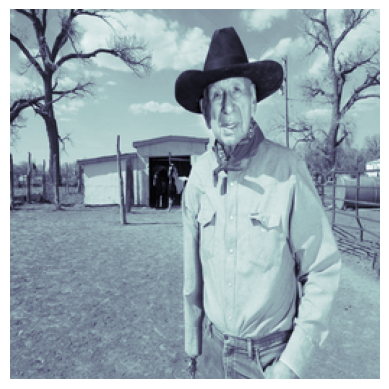

In [89]:
plt.imshow(Image.fromarray(image_colored_rgb))
plt.axis('off')
plt.show()

In [44]:
CNN_face_detection = model_CNN_face_detection(*IMAGE_SIZE)
CNN_face_detection.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
CNN_face_detection.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 dropout (Dropout)           (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 125, 125, 64)     

In [45]:
checkpoint = ModelCheckpoint(CHECKPOINTS_DIR / "best_model_CNN_face_detection_default.hdf5", 
                             monitor='val_loss', verbose=1, save_best_only=True, save_freq='epoch')

In [46]:
history_2 = CNN_face_detection.fit(X_train, y_train, validation_data=(X_test, y_test),
                                   batch_size=16, epochs=15, 
                                   callbacks=[checkpoint], use_multiprocessing=True, workers=CORES)

Epoch 1/15
33/33 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.7055
Epoch 1: val_loss improved from inf to 0.02304, saving model to /home/prokhor/PycharmProjects/pythonProject1/data/lab2/checkpoints/best_model_CNN_face_detection_default.hdf5
33/33 [==============================] - 29s 833ms/step - loss: 0.0353 - accuracy: 0.7055 - val_loss: 0.0230 - val_accuracy: 0.8571
Epoch 2/15
33/33 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.7629
Epoch 2: val_loss did not improve from 0.02304
33/33 [==============================] - 29s 868ms/step - loss: 0.0283 - accuracy: 0.7629 - val_loss: 0.0258 - val_accuracy: 0.8571
Epoch 3/15
33/33 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.7438
Epoch 3: val_loss did not improve from 0.02304
33/33 [==============================] - 30s 904ms/step - loss: 0.0284 - accuracy: 0.7438 - val_loss: 0.0274 - val_accuracy: 0.8571
Epoch 4/15
33/33 [==============================] - ET

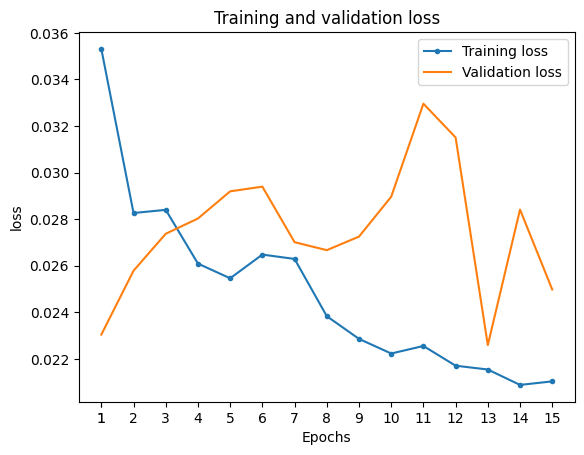

In [47]:
plot_metric(history_2, 'loss', k=1)

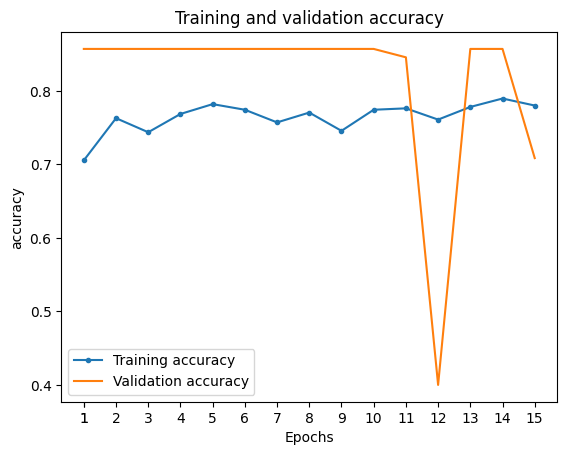

In [48]:
plot_metric(history_2, 'accuracy', k=1)

In [49]:
CNN_face_detection_default = load_model(CHECKPOINTS_DIR / 'best_model_CNN_face_detection_default.hdf5')

In [50]:
CNN_face_detection_default.evaluate(X_test, y_test, batch_size=32)

6/6 [==============================] - 2s 317ms/step - loss: 0.0226 - accuracy: 0.8571


[0.02259080298244953, 0.8571428656578064]

1/1 [==============================] - 0s 29ms/step


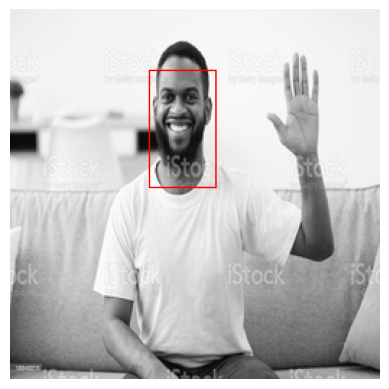

In [95]:
plot_image_with_predicted_box(CNN_face_detection_default, default_dataset['00001033.jpg']['image'])

In [72]:
indexes = list(range(len(default_dataset)))
tuple_of_indexes = train_test_split(indexes, indexes, test_size=0.25, random_state=RS)
X_train, X_test, y_train, y_test = get_train_test_by_indexes(enhanced_dataset, tuple_of_indexes)
X_train.shape, y_train.shape

((524, 256, 256, 1), (524, 4))

In [73]:
CNN_face_detection = model_CNN_face_detection(*IMAGE_SIZE)
CNN_face_detection.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
CNN_face_detection.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 dropout_4 (Dropout)         (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 dropout_5 (Dropout)         (None, 125, 125, 64)     

In [74]:
checkpoint = ModelCheckpoint(CHECKPOINTS_DIR / "best_model_CNN_face_detection_enhanced.hdf5", 
                             monitor='val_loss', verbose=1, save_best_only=True, save_freq='epoch')

In [75]:
history_3 = CNN_face_detection.fit(X_train, y_train, validation_data=(X_test, y_test),
                                   batch_size=16, epochs=15, 
                                   callbacks=[checkpoint], use_multiprocessing=True, workers=CORES)

Epoch 1/15
33/33 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.7118
Epoch 1: val_loss improved from inf to 0.02669, saving model to /home/prokhor/PycharmProjects/pythonProject1/data/lab2/checkpoints/best_model_CNN_face_detection_enhanced.hdf5
33/33 [==============================] - 29s 833ms/step - loss: 0.0381 - accuracy: 0.7118 - val_loss: 0.0267 - val_accuracy: 0.8057
Epoch 2/15
33/33 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.7729
Epoch 2: val_loss did not improve from 0.02669
33/33 [==============================] - 29s 869ms/step - loss: 0.0317 - accuracy: 0.7729 - val_loss: 0.0290 - val_accuracy: 0.8057
Epoch 3/15
33/33 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.7672
Epoch 3: val_loss did not improve from 0.02669
33/33 [==============================] - 30s 923ms/step - loss: 0.0316 - accuracy: 0.7672 - val_loss: 0.0311 - val_accuracy: 0.8057
Epoch 4/15
33/33 [==============================] - E

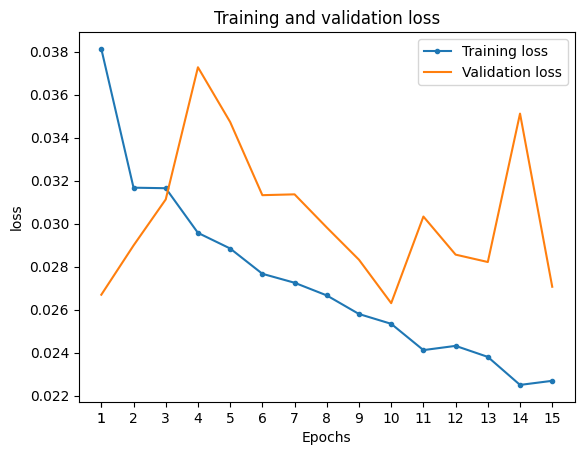

In [76]:
plot_metric(history_3, 'loss', k=1)

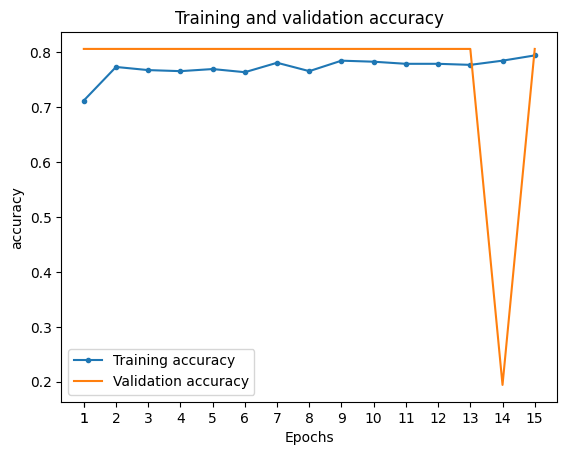

In [77]:
plot_metric(history_3, 'accuracy', k=1)

In [78]:
CNN_face_detection_enhanced = load_model(CHECKPOINTS_DIR / 'best_model_CNN_face_detection_enhanced.hdf5')

1/1 [==============================] - 0s 33ms/step


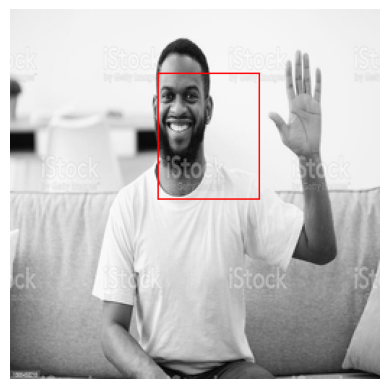

In [94]:
plot_image_with_predicted_box(CNN_face_detection_enhanced, enhanced_dataset['00001033.jpg']['image'])

## Третє завдання

In [96]:
def create_adversarial_pattern(input_image, input_label, model) -> tf.Tensor:
    loss_object = tf.keras.losses.MeanSquaredError()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    
    return signed_grad

def perform_fgsm(input_image, input_label, model, epsilon=0.01) -> np.ndarray:
    perturbations = create_adversarial_pattern(input_image, input_label, model)
    adversarial_image = input_image + epsilon * perturbations
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    adversarial_image = np.squeeze(adversarial_image.numpy(), axis=0)
    return adversarial_image

In [107]:
img_name = '00002096.jpg'

input_image_np = default_dataset[img_name]['image']
input_label = default_dataset[img_name]['box']

input_image = input_image_np.reshape((1, *IMAGE_SIZE, 1))
input_label = np.expand_dims(input_label, axis=0)

input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
input_label = tf.convert_to_tensor(input_label, dtype=tf.float32)

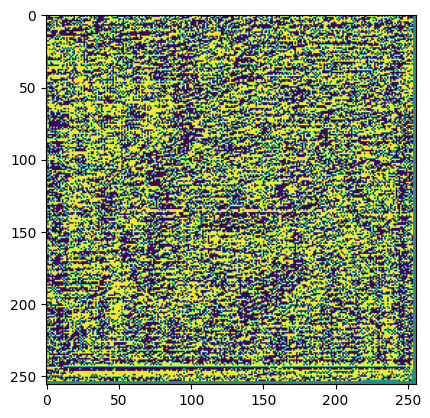

In [108]:
perturbations = create_adversarial_pattern(input_image, input_label, CNN_face_detection_default)
plt.imshow(perturbations[0] * 0.5 + 0.5)

1/1 [==============================] - 0s 27ms/step


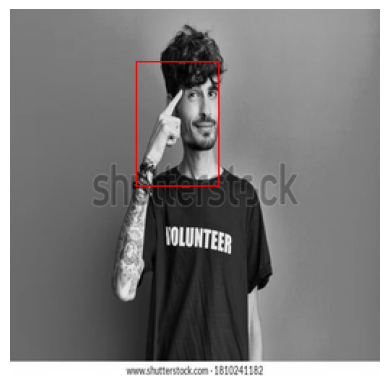

In [109]:
adversarial_image = perform_fgsm(input_image, input_label, CNN_face_detection_default, epsilon=1)
plot_image_with_predicted_box(CNN_face_detection_default, input_image_np)

In [110]:
input_image_np.mean(), adversarial_image[0].mean()

(0.4553225648169424, 0.46502757)

In [111]:
img_name = '00002096.jpg'

input_image_np = enhanced_dataset[img_name]['image']
input_label = enhanced_dataset[img_name]['box']

input_image = input_image_np.reshape((1, *IMAGE_SIZE, 1))
input_label = np.expand_dims(input_label, axis=0)

input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
input_label = tf.convert_to_tensor(input_label, dtype=tf.float32)

1/1 [==============================] - 0s 28ms/step


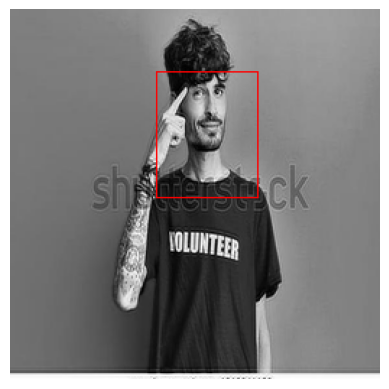

In [112]:
adversarial_image = perform_fgsm(input_image, input_label, CNN_face_detection_enhanced, epsilon=1)
plot_image_with_predicted_box(CNN_face_detection_enhanced, input_image_np)

In [113]:
input_image_np.mean(), adversarial_image[0].mean()

(0.44315999348958335, 0.48114276)